In [1]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np
import re
import math
import ipywidgets as widgets
from IPython.display import display

# Setup sqlite Datenbank
Datenbank wird im Verzeichnis "C:\MA_Pethke_3992454" abgelegt

In [2]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454_idea_1.db")
cur = con.cursor()

In [3]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokumente(PMID INTEGER UNIQUE, titel TEXT, pubdate DATE)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, CitingPMID INETEGER)")

#------------------- Tabelle Mesh --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh(UI VARCHAR UNIQUE, name TEXT, datum DATE)")

#------------------- Tabelle Mesh - PMID --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh_PMID(UI VARCHAR, PMID INTEGER)")

#------------------- Tabelle Abfrage --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Abfrage(QID INTEGER PRIMARY KEY AUTOINCREMENT, query TEXT, PMID INTEGER, ranking INTEGER, mesh VARCHAR)")
con.commit()

# Allgemeine Abfragen aus DB

In [4]:
def getPubDate(pmid):
    cur.execute("SELECT strftime('%Y', pubdate) FROM Dokumente WHERE PMID = \""+ str(pmid)+ "\"")
    pubdate = int(cur.fetchall()[0][0])
    return pubdate

In [5]:
def getMeSHYear(meshUI):
    cur.execute("SELECT strftime('%Y', datum) FROM Mesh WHERE UI = \""+ str(meshUI)+ "\"")
    meshYear = int(cur.fetchall()[0][0])
    return meshYear

# MeSH Data

In [6]:
meshTerm = "Metabolism"

requ = requests.get("https://id.nlm.nih.gov/mesh/lookup/descriptor?label="+meshTerm+"&year=current&limit=10", headers={"Accept": "application/json"})
meshData = requ.json()

In [7]:
print(meshData)

[{'resource': 'http://id.nlm.nih.gov/mesh/D008660', 'label': 'Metabolism'}]


In [8]:
meshUI = "D001241"
meshTerm = "aspirin"
requ = requests.get("https://id.nlm.nih.gov/mesh/"+str(meshUI)+".json", headers={"Accept": "application/json"})
meshData = requ.json()
meshDate = meshData["dateCreated"]

In [9]:
def insertMeshData_db(meshUI_loc, meshTerm_loc, meshDate_loc):
    try:
        cur.execute("INSERT INTO Mesh (UI, name, datum) VALUES (\""+str(meshUI_loc)+"\", \""+str(meshTerm_loc)+"\", \""+str(meshDate_loc)+"\")")
        con.commit()
    except:
        print("MeSH schon in DB")

In [10]:
# insertMeshData_db(meshUI, meshTerm, meshDate)

# Dokumente zu MeSH von PubMed

In [11]:
limit = 20 # API limited to first 10000 documents; esearch is a way to get all data, but u have to work on an unix environment https://dataguide.nlm.nih.gov/edirect/edirect-vs-e-utilities.html
# Abfrage von Dokumente, die vor der Aufnahme des MeSHs veröffentlicht wurden (Von 1900 an)
meshYear = getMeSHYear(meshUI)
requ = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("+urllib.parse.quote(meshTerm)+"[MeSH+Terms])+AND+((\"1900\"[Date+-+Publication]+%3A+\""+str(meshYear)+"\"[Date+-+Publication]))&retmax="+str(limit)+"&sort=relevance&retmode=json&offset=")
requ_json = json.loads(requ.text)
print(requ_json)
pmidList = requ_json['esearchresult']['idlist']
countResult = requ_json['esearchresult']['count']

{'header': {'type': 'esearch', 'version': '0.3'}, 'esearchresult': {'count': '22495', 'retmax': '20', 'retstart': '0', 'idlist': ['8205012', '2029587', '9282411', '2030640', '287960', '1899486', '845363', '67396', '2519899', '7805939', '2191940', '4121596', '7763529', '5909852', '1165647', '8369590', '4947388', '790585', '9456577', '9851731'], 'translationset': [{'from': 'aspirin[MeSH Terms]', 'to': '"aspirin"[MeSH Terms]'}], 'querytranslation': '"aspirin"[MeSH Terms] AND 1900/01/01:1999/12/31[Date - Publication]'}}


In [12]:
def insertMeshPmid(meshUI_loc, pmidList):
    for pmid in pmidList:
        cur.execute('INSERT INTO Mesh_PMID (UI, PMID) VALUES ("'+str(meshUI_loc)+'", "'+str(pmid)+'")')
        con.commit()


def getDokDataFromPmid(pmid):
    # Daten zu einzelner PMID
    requ = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmid)))
    # Formatierung
    xpars = xmltodict.parse(requ.text)
    json_str = json.dumps(xpars, indent=4)
    json_data = json.loads(json_str)

    ## Titel 
    titleWithout = ""
    try:
        title = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleTitle"]
        titleWithout = title.replace('"', "'")
    except:
        try:
            title = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleTitle"]["#text"]
            titleWithout = title.replace('"', "'")
        except:
            print("Kein Titel zu PMID:", str(pmid))

    ## PubDate
    pubDate = datetime.datetime(1,1,1)
    # Nicht alle Dokumente haben ein eigenes Veröffentlichungsdatum, dann wird sich auf das DateCompleted von PubMed berufen (TODO: recherchieren, was das genau ist)
    try:
        pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleDate"]
        pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))
    except:
        pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["PubmedData"]["History"]["PubMedPubDate"][0]
        pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))
    return titleWithout, pubDate

def insertDokData_db(pmidList_loc):
    for pmid in pmidList_loc:
        print(pmid)
        try:
            titleWithout, pubDate = getDokDataFromPmid(pmid)
        except:
            titleWithout, pubDate = "ERROR", datetime.datetime(1,1,1)
        
        try:
            cur.execute('INSERT INTO Dokumente (PMID, titel, pubdate) VALUES ("'+str(pmid)+'", "'+str(titleWithout)+'", "'+str(pubDate)+'")')
            con.commit()
        except:
            print("Dokument schon in DB")


In [13]:
# insertMeshPmid(meshUI, pmidList)
# insertDokData_db(pmidList)

# Zitationsdaten erheben

In [14]:
def getAllCitingPMIDs(pmid):
    response_PubMedMCitations = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&id="+urllib.parse.quote(str(pmid)))
    # Formatierung
    xpars = xmltodict.parse(response_PubMedMCitations.text)
    json_str = json.dumps(xpars, indent=4)
    json_data = json.loads(json_str)
    try:
        citingPMIDs = [x["Id"] for x in json_data["eLinkResult"]["LinkSet"]["LinkSetDb"]["Link"]]
        print("PMID: ", pmid, "Anzahl Zitationen: ", len(citingPMIDs))
    except:
        citingPMIDs = []
        print("PMID: ", pmid, "Anzahl Zitationen: 0")
    return citingPMIDs

def insertCitationPMIDCombi(pmid, citingPmids):
    # Wenn Zitationen eines Dokuments schon erhoben wurden, dann nicht nochmal alle durchgehen
    cur.execute("SELECT count(PMID) FROM Zitationen WHERE PMID = "+ str(pmid))
    if cur.fetchall()[0][0] == 0:
        return
    else:
        for citingPMID in citingPmids:
            try:
                cur.execute('INSERT INTO Zitationen (PMID, CitingPMID) VALUES ("'+str(pmid)+'", "'+str(citingPMID)+'")')
                con.commit()
            except:
                print("Zitationskombi schon in DB")

def insertCitingPMIDs(pmidList_loc):
    for pmid in pmidList_loc:
        citingPMIDs = getAllCitingPMIDs(pmid)
        # Fügt alle Dokumente in Tabelle "Dokumente" 
        insertDokData_db(citingPMIDs)
        insertCitationPMIDCombi(pmid, citingPMIDs)

In [15]:
# insertCitingPMIDs(pmidList)

# Zitationsdaten in Verhältnis zu MeSH

In [16]:
def getDateOfMeSH(meshUI):
    cur.execute("SELECT datum FROM Mesh WHERE UI = \""+ str(meshUI)+ "\"")
    meshDate = datetime.datetime.strptime(cur.fetchall()[0][0], "%Y-%m-%d").date()
    return meshDate


def getCitationDataForPMID(pmid):
    # für jede PMID in idList die zitierenden PMIDs abfragen
    cur.execute("SELECT CitingPMID FROM Zitationen WHERE PMID = \""+ str(pmid)+ "\"")
    citingPMIDs =  [x[0] for x in cur.fetchall()]
    if len(citingPMIDs) == 0:
        # print(citationData)
        # print(pmid, "Zu diesem Dokument liegen keine Zitationsdaten vor")
        citationData = [[], []]
    else:
        # SQLite Abfrage erstellen
        queryCitingPMIDs = "PMID = " + str(citingPMIDs[0])
        if len(citingPMIDs) > 1:
            for citingPMID in citingPMIDs[1:]:
                queryCitingPMIDs = queryCitingPMIDs + " or PMID = " + str(citingPMID)
        query = "SELECT strftime('%Y', pubdate) as year, count(strftime('%Y', pubdate)) as count FROM Dokumente WHERE "+queryCitingPMIDs+" GROUP BY year"
        cur.execute(query)
        output = cur.fetchall()
        years = [int(x[0]) for x in output]
        citationCounts = [int(x[1]) for x in output]
        citationData = [years, citationCounts]
    return citationData

In [17]:
# getCitationDataForPMID(17523700)

# Visualisierung

In [18]:
def plotMeSHIntrosPerPmid(pmid):
    pubDate = getPubDate(pmid)
    meshDate = getMeSHYear(meshUI)
    years, counts = getCitationDataForPMID(pmid)
    if len(years) == 0:
          print("Zu diesem Dokument liegen keine Zitationdaten vor.")
    else:
          fig, ax = plt.subplots(layout="constrained")
          ax.set_ylabel("Anzahl Zitationen")
          ax.set_xlabel("Jahre")
          ax.set_title("PMID: " + str(pmid))
          ax.set_xlim(min(pubDate, meshDate)-5, 2023)
          ax.set_ylim(0, 50)
          ax.bar(years, counts)
          ax.annotate("Veröffentlichungsjahr",
               xy=(pubDate, 20), 
               xycoords="data",
               xytext=(0, 50),
               textcoords="offset points", 
               arrowprops=dict(facecolor="blue"))
          
          ax.annotate("MeSH Aufnahme",
               xy=(meshDate, 20), 
               xycoords="data",
               xytext=(0, 50),
               textcoords="offset points", 
               arrowprops=dict(facecolor="red"))

In [19]:
def f(x):
    return x



In [20]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [21]:
widgets.interact(f, x=['apples','oranges'])

interactive(children=(Dropdown(description='x', options=('apples', 'oranges'), value='apples'), Output()), _do…

<function __main__.f(x)>

In [ ]:
# widgets.interact(plotMeSHIntrosPerPmid, x=pmidList)

Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.
Zu diesem Dokument liegen keine Zitationdaten vor.


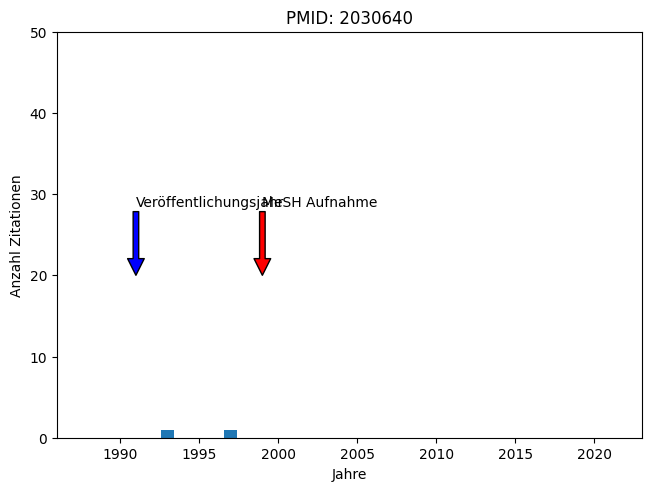

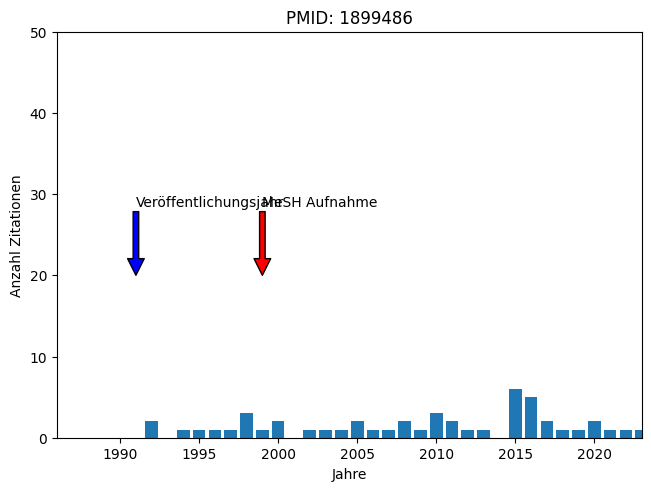

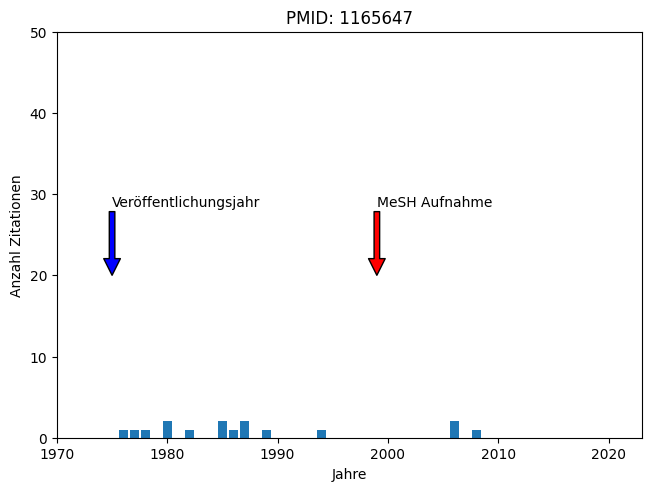

In [24]:
for pmid in pmidList:
     plotMeSHIntrosPerPmid(pmid)